## Import packages

In [72]:
import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
import torch.optim as optim                             # Optimization algorithms
from torch import nn                                    # Neural network modules
from torch.utils.data import Dataset, DataLoader        # Dataset and batch data loading
from datetime import datetime                           # Date/time utilities
import os                                               # Operating system utilities
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data

import deepSSF_model                                    # Import the .py file containing the deepSSF model     
import deepSSF_loss                                     # Import the .py file containing the deepSSF loss function
import deepSSF_early_stopping                           # Import the .py file containing the early stopping function                                     

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Set random seed for reproducibility
seed = 42

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


### If using Google Colab, uncomment the following lines

The file directories will also need to be changed to match the location of the files in your Google Drive.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import data

## Set paths to data

In [50]:
buffalo_id = 2005
n_samples = 10297

# Specify the path to CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Path to your TIF file (slope)
slope_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_slope_cent101x101_lag_1hr_n{n_samples}.tif'

# Paths to the Sentinel-2 bands
b1_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b1_cent101x101_lag_1hr_n{n_samples}.tif'
b2_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b2_cent101x101_lag_1hr_n{n_samples}.tif'
b3_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b3_cent101x101_lag_1hr_n{n_samples}.tif'
b4_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b4_cent101x101_lag_1hr_n{n_samples}.tif'
b5_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b5_cent101x101_lag_1hr_n{n_samples}.tif'
b6_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b6_cent101x101_lag_1hr_n{n_samples}.tif'
b7_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b7_cent101x101_lag_1hr_n{n_samples}.tif'
b8_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b8_cent101x101_lag_1hr_n{n_samples}.tif'
b8a_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b8a_cent101x101_lag_1hr_n{n_samples}.tif'
b9_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b9_cent101x101_lag_1hr_n{n_samples}.tif'
b11_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b11_cent101x101_lag_1hr_n{n_samples}.tif'
b12_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b12_cent101x101_lag_1hr_n{n_samples}.tif'

# Path to your TIF file (target variable)
pres_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_pres_cent101x101_lag_1hr_n{n_samples}.tif'


## Read buffalo data

In [5]:
# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)
print(buffalo_df.shape)

# Lag the values in column 'A' by one index to get the bearing of the previous step
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

(10103, 35)
             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

     cos_ta         x_min         x_max         y_min         y_max  s2_index  \
0  0.

## Importing spatial data

## Slope

In [6]:
# Using rasterio
with rasterio.open(slope_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(10103, 101, 101)


In [ ]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)

# Print the mean, max, and min values of the slope tensor
print("Mean = ", torch.mean(slope_tens))
slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)
print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens))
print("Max = ", torch.max(slope_tens))
print("Min = ", torch.min(slope_tens))

torch.Size([10103, 101, 101])
Mean =  tensor(0.7779)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0632)
Max =  tensor(1.)
Min =  tensor(0.)


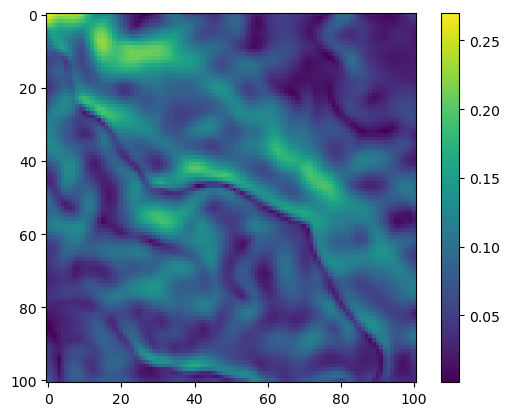

In [ ]:
for i in range(0, 1):
    plt.imshow(slope_tens[i])
    plt.colorbar()
    plt.show()

## Sentinel-2 bands

During the data preparation (in the `deepSSF_data_prep_id_S2` script) for the Sentinel-2 bands, we scaled them by 10,000, so we do not need to scale them again here (as we did for the other covariates). 

### Band 1

In [9]:
# Using rasterio
with rasterio.open(b1_path) as b1:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b1_stack = b1.read([i for i in range(1, b1.count + 1)])

In [10]:
# Print the shape of the original b1_stack array
print(b1_stack.shape)

# Replace NaNs with -1
b1_stack = np.nan_to_num(b1_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b1_tens = torch.from_numpy(b1_stack)
print(b1_tens.shape)

# Display the mean, max, and min values of the b1 tensor
print(f'Min =  {torch.min(b1_tens)}')
print(f'Mean = {torch.mean(b1_tens)}')
print(f'Max =  {torch.max(b1_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  9.999999747378752e-05
Mean = 0.04444880783557892
Max =  0.1517084836959839


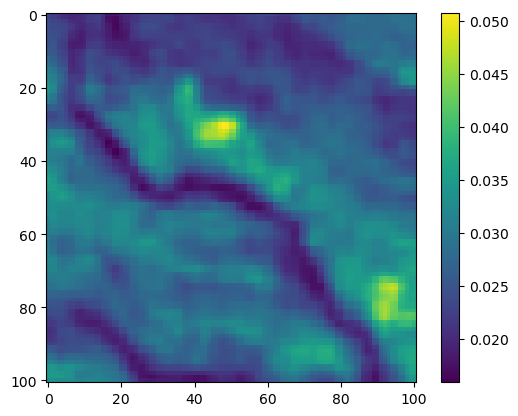

In [12]:
for i in range(0, 1):
    plt.imshow(b1_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 2

In [14]:
# Using rasterio
with rasterio.open(b2_path) as b2:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b2_stack = b2.read([i for i in range(1, b2.count + 1)])

In [15]:
# Print the shape of the original b2_stack array
print(b2_stack.shape)

# Replace NaNs with -1
b2_stack = np.nan_to_num(b2_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b2_tens = torch.from_numpy(b2_stack)
print(b2_tens.shape)

# Display the mean, max, and min values of the b2 tensor
print(f'Min =  {torch.min(b2_tens)}')
print(f'Mean = {torch.mean(b2_tens)}')
print(f'Max =  {torch.max(b2_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.002810720121487975
Mean = 0.05629923567175865
Max =  0.1931755244731903


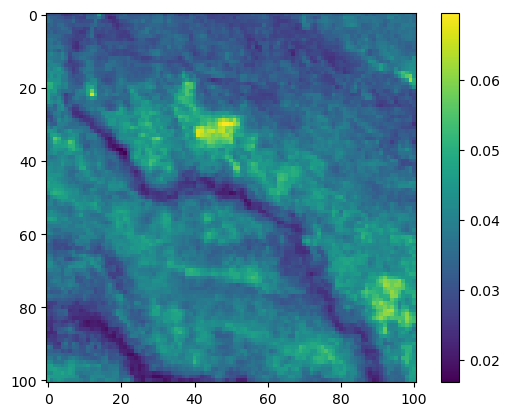

In [16]:
for i in range(0, 1):
    plt.imshow(b2_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 3

In [17]:
# Using rasterio
with rasterio.open(b3_path) as b3:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b3_stack = b3.read([i for i in range(1, b3.count + 1)])

In [18]:
# Print the shape of the original b3_stack array
print(b3_stack.shape)

# Replace NaNs with -1
b3_stack = np.nan_to_num(b3_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b3_tens = torch.from_numpy(b3_stack)
print(b3_tens.shape)

# Display the mean, max, and min values of the b3 tensor
print(f'Min =  {torch.min(b3_tens)}')
print(f'Mean = {torch.mean(b3_tens)}')
print(f'Max =  {torch.max(b3_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.02109863981604576
Mean = 0.08027872443199158
Max =  0.2795756757259369


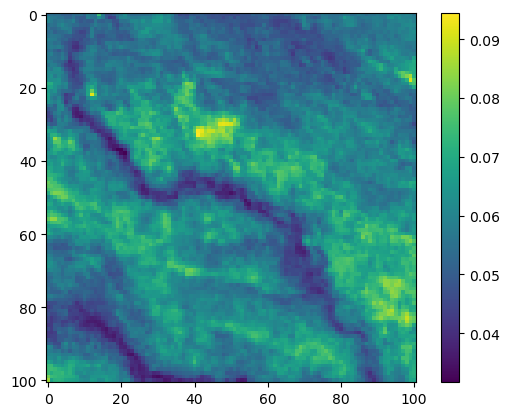

In [19]:
for i in range(0, 1):
    plt.imshow(b3_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 4

In [20]:
# Using rasterio
with rasterio.open(b4_path) as b4:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b4_stack = b4.read([i for i in range(1, b4.count + 1)])

In [21]:
# Print the shape of the original b4_stack array
print(b4_stack.shape)

# Replace NaNs with -1
b4_stack = np.nan_to_num(b4_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b4_tens = torch.from_numpy(b4_stack)
print(b4_tens.shape)

# Display the mean, max, and min values of the b4 tensor
print(f'Min =  {torch.min(b4_tens)}')
print(f'Mean = {torch.mean(b4_tens)}')
print(f'Max =  {torch.max(b4_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.006578320171684027
Mean = 0.09937984496355057
Max =  0.43867969512939453


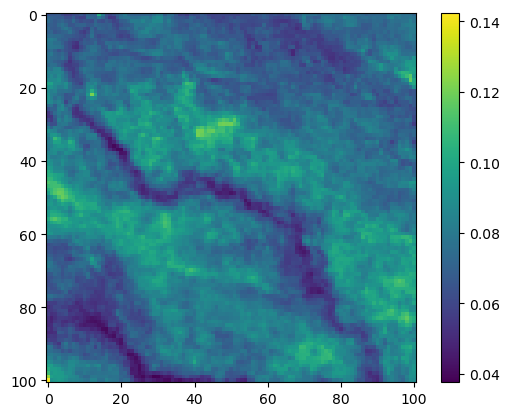

In [22]:
for i in range(0, 1):
    plt.imshow(b4_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 5

In [23]:
# Using rasterio
with rasterio.open(b5_path) as b5:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b5_stack = b5.read([i for i in range(1, b5.count + 1)])

In [24]:
# Print the shape of the original b5_stack array
print(b5_stack.shape)

# Replace NaNs with -1
b5_stack = np.nan_to_num(b5_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b5_tens = torch.from_numpy(b5_stack)
print(b5_tens.shape)

# Display the mean, max, and min values of the b5 tensor
print(f'Min =  {torch.min(b5_tens)}')
print(f'Mean = {torch.mean(b5_tens)}')
print(f'Max =  {torch.max(b5_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.03587600216269493
Mean = 0.136901393532753
Max =  0.4592735767364502


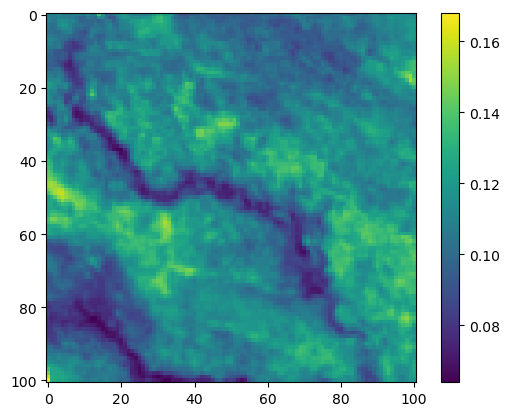

In [25]:
for i in range(0, 1):
    plt.imshow(b5_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 6

In [26]:
# Using rasterio
with rasterio.open(b6_path) as b6:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b6_stack = b6.read([i for i in range(1, b6.count + 1)])

In [27]:
# Print the shape of the original b6_stack array
print(b6_stack.shape)

# Replace NaNs with -1
b6_stack = np.nan_to_num(b6_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b6_tens = torch.from_numpy(b6_stack)
print(b6_tens.shape)

# Display the mean, max, and min values of the b6 tensor
print(f'Min =  {torch.min(b6_tens)}')
print(f'Mean = {torch.mean(b6_tens)}')
print(f'Max =  {torch.max(b6_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.038534000515937805
Mean = 0.17727355659008026
Max =  0.5120914578437805


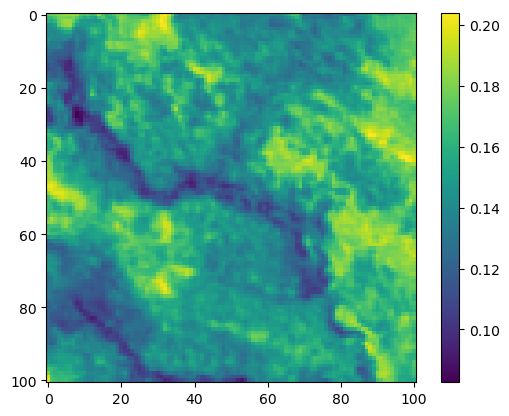

In [28]:
for i in range(0, 1):
    plt.imshow(b6_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 7

In [29]:
# Using rasterio
with rasterio.open(b7_path) as b7:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b7_stack = b7.read([i for i in range(1, b7.count + 1)])

In [30]:
# Print the shape of the original b7_stack array
print(b7_stack.shape)

# Replace NaNs with -1
b7_stack = np.nan_to_num(b7_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b7_tens = torch.from_numpy(b7_stack)
print(b7_tens.shape)

# Display the mean, max, and min values of the b7 tensor
print(f'Min =  {torch.min(b7_tens)}')
print(f'Mean = {torch.mean(b7_tens)}')
print(f'Max =  {torch.max(b7_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.04165744036436081
Mean = 0.19983430206775665
Max =  0.6045699119567871


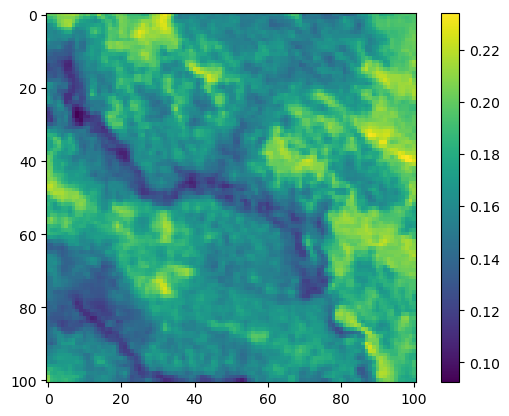

In [31]:
for i in range(0, 1):
    plt.imshow(b7_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 8

In [32]:
# Using rasterio
with rasterio.open(b8_path) as b8:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b8_stack = b8.read([i for i in range(1, b8.count + 1)])

In [33]:
# Print the shape of the original b8_stack array
print(b8_stack.shape)

# Replace NaNs with -1
b8_stack = np.nan_to_num(b8_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b8_tens = torch.from_numpy(b8_stack)
print(b8_tens.shape)

# Display the mean, max, and min values of the b8 tensor
print(f'Min =  {torch.min(b8_tens)}')
print(f'Mean = {torch.mean(b8_tens)}')
print(f'Max =  {torch.max(b8_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.03680320084095001
Mean = 0.2095790058374405
Max =  0.6004582643508911


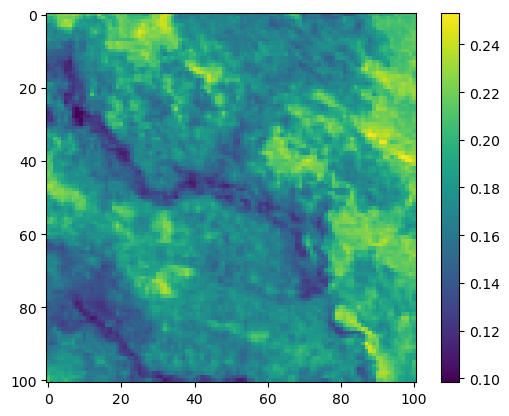

In [34]:
for i in range(0, 1):
    plt.imshow(b8_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 8a

In [35]:
# Using rasterio
with rasterio.open(b8a_path) as b8a:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b8a_stack = b8a.read([i for i in range(1, b8a.count + 1)])

In [36]:
# Print the shape of the original b8a_stack array
print(b8a_stack.shape)

# Replace NaNs with -1
b8a_stack = np.nan_to_num(b8a_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b8a_tens = torch.from_numpy(b8a_stack)
print(b8a_tens.shape)

# Display the mean, max, and min values of the b8a tensor
print(f'Min =  {torch.min(b8a_tens)}')
print(f'Mean = {torch.mean(b8a_tens)}')
print(f'Max =  {torch.max(b8a_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.03570704162120819
Mean = 0.22782425582408905
Max =  0.6218413710594177


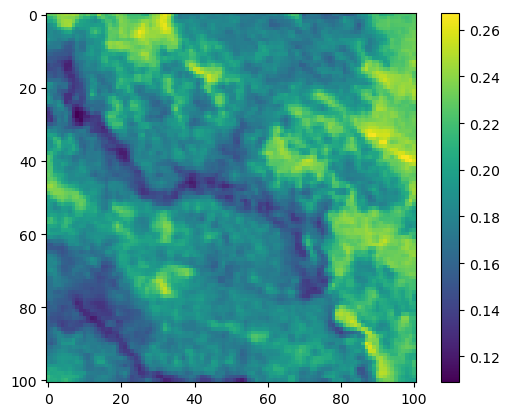

In [37]:
for i in range(0, 1):
    plt.imshow(b8a_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 9

In [38]:
# Using rasterio
with rasterio.open(b9_path) as b9:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b9_stack = b9.read([i for i in range(1, b9.count + 1)])

In [39]:
# Print the shape of the original b9_stack array
print(b9_stack.shape)

# Replace NaNs with -1
b9_stack = np.nan_to_num(b9_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b9_tens = torch.from_numpy(b9_stack)
print(b9_tens.shape)

# Display the mean, max, and min values of the b9 tensor
print(f'Min =  {torch.min(b9_tens)}')
print(f'Mean = {torch.mean(b9_tens)}')
print(f'Max =  {torch.max(b9_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.012299999594688416
Mean = 0.22701694071292877
Max =  0.5680500268936157


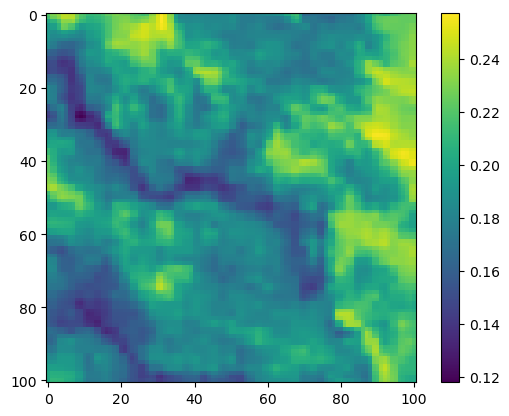

In [40]:
for i in range(0, 1):
    plt.imshow(b9_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 11

In [51]:
# Using rasterio
with rasterio.open(b11_path) as b11:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b11_stack = b11.read([i for i in range(1, b11.count + 1)])

In [52]:
# Print the shape of the original b11_stack array
print(b11_stack.shape)

# Replace NaNs with -1
b11_stack = np.nan_to_num(b11_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b11_tens = torch.from_numpy(b11_stack)
print(b11_tens.shape)

# Display the mean, max, and min values of the b11 tensor
print(f'Min =  {torch.min(b11_tens)}')
print(f'Mean = {torch.mean(b11_tens)}')
print(f'Max =  {torch.max(b11_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.01741199940443039
Mean = 0.27866700291633606
Max =  0.657039225101471


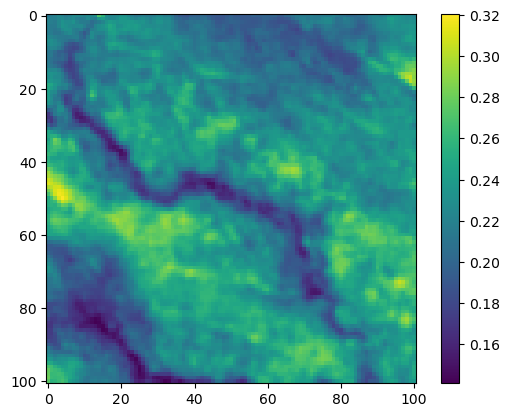

In [53]:
for i in range(0, 1):
    plt.imshow(b11_tens[i].numpy())
    plt.colorbar()
    plt.show()

## Band 12

In [44]:
# Using rasterio
with rasterio.open(b12_path) as b12:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b12_stack = b12.read([i for i in range(1, b1.count + 1)])

In [47]:
# Print the shape of the original b12_stack array
print(b12_stack.shape)

# Replace NaNs with -1
b12_stack = np.nan_to_num(b12_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b12_tens = torch.from_numpy(b12_stack)
print(b12_tens.shape)

# Display the mean, max, and min values of the b12 tensor
print(f'Min =  {torch.min(b12_tens)}')
print(f'Mean = {torch.mean(b12_tens)}')
print(f'Max =  {torch.max(b12_tens)}')

(10103, 101, 101)
torch.Size([10103, 101, 101])
Min =  0.012337599880993366
Mean = 0.19245100021362305
Max =  0.5119996666908264


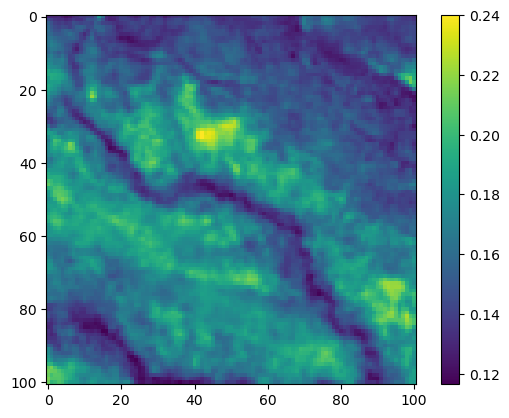

In [48]:
for i in range(0, 1):
    plt.imshow(b12_tens[i].numpy())
    plt.colorbar()
    plt.show()

## View as RGB

Given the Red (B4), Green (B3), and Blue (B2) bands, we can create an RGB image.

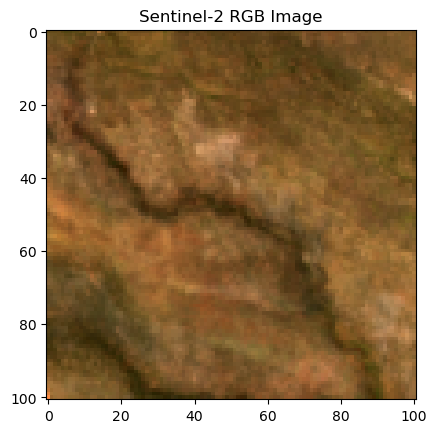

In [55]:
# Assuming b4_tens, b3_tens, and b2_tens are your tensors
rgb_image = torch.stack([b4_tens, b3_tens, b2_tens], dim=-1)

# Convert to NumPy
rgb_image_np = rgb_image[0].cpu().numpy()

# Normalize to the range [0, 1] for display
rgb_image_np = (rgb_image_np - rgb_image_np.min()) / (rgb_image_np.max() - rgb_image_np.min())

# Display the image
plt.imshow(rgb_image_np)
plt.title('Sentinel-2 RGB Image')
plt.show()

## Presence records - target of model

The target is what we are trying to predict with the deepSSF model, with is the location of the observed next step.

In [56]:
# Using rasterio
with rasterio.open(pres_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)
print(type(pres_stack))

(10103, 101, 101)
<class 'numpy.ndarray'>


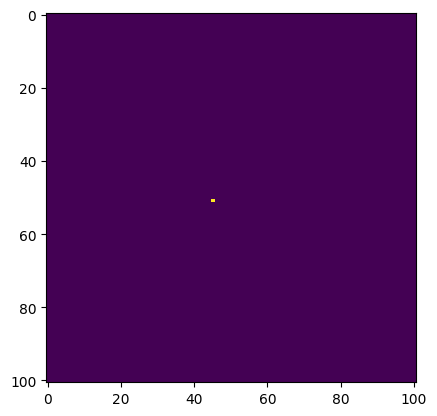

In [ ]:
for i in range(0, 1):
    plt.imshow(pres_stack[i])
    plt.show()

In [57]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


### Combine the spatial layers into channels

In [58]:
# use sentinel-2 bands
combined_stack = torch.stack([b1_tens, 
                              b2_tens, 
                              b3_tens, 
                              b4_tens,
                              b5_tens, 
                              b6_tens, 
                              b7_tens, 
                              b8_tens,
                              b8a_tens, 
                              b9_tens, 
                              b11_tens, 
                              b12_tens,
                              slope_tens], 
                              dim=1)

print(combined_stack.shape)

torch.Size([10103, 13, 101, 101])


## Defining data sets and data loaders

### Creating a dataset class

This custom PyTorch Dataset organizes all your input (spatial data, scalar covariates, bearing, and target) in a single object, allowing you to neatly manage how samples are accessed. The `__init__` method prepares and stores all the data, `__len__` returns the total number of samples, and `__getitem__` retrieves a single sample by index—enabling straightforward batching and iteration when used with a DataLoader.

In [59]:
class buffalo_data(Dataset):

    def __init__(self):
        # data loading
        self.spatial_data_x = combined_stack

        # the scalar data that will be converted to grid data and added to the spatial covariates for CNN components
        self.scalar_to_grid_data = torch.from_numpy(buffalo_df[['hour_t2_sin', 
                                                                'hour_t2_cos', 
                                                                'yday_t2_sin', 
                                                                'yday_t2_cos']].values).float()

       # the bearing data that will be added as a channel to the spatial covariates
        self.bearing_x = torch.from_numpy(buffalo_df[['bearing_tm1']].values).float()

        # the target data
        self.target = torch.tensor(pres_stack)

        # number of samples
        self.n_samples = self.spatial_data_x.shape[0]

    def __len__(self):
        # allows for the use of len() function
        return self.n_samples

    def __getitem__(self, index):
        # allows for indexing of the dataset
        return self.spatial_data_x[index], self.scalar_to_grid_data[index], self.bearing_x[index], self.target[index]

Now we can create an instance of the dataset class and check that is working as expected.

In [61]:
# Create an instance of our custom buffalo_data Dataset:
dataset = buffalo_data()

# Print the total number of samples loaded (determined by n_samples in the dataset):
print(dataset.n_samples)

# Retrieve *all* samples (using the slice dataset[:] invokes __getitem__ on all indices).
# This returns a tuple of (spatial data, scalar-to-grid data, bearing data, target labels).
features1, features2, features3, labels = dataset[:]

# Examine the dimensions of each returned tensor for verification:

# Spatial data
print(features1.shape)

# Scalar-to-grid data
print(features2.shape)

# Bearing data
print(features3.shape)

# Target labels
print(labels.shape)

10103
torch.Size([10103, 13, 101, 101])
torch.Size([10103, 4])
torch.Size([10103, 1])
torch.Size([10103, 101, 101])


### Split into training, validation and test sets

In [62]:
training_split = 0.8 # 80% of the data will be used for training
validation_split = 0.1 # 10% of the data will be used for validation (deciding when to stop training)
test_split = 0.1 # 10% of the data will be used for testing (model evaluation)

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [training_split, validation_split, test_split])
print("Number of training samples: ", len(dataset_train))
print("Number of validatiom samples: ", len(dataset_val))
print("Number of testing samples: ", len(dataset_test))

Number of training samples:  8083
Number of validatiom samples:  1010
Number of testing samples:  1010


### Create dataloaders

The DataLoader in PyTorch wraps an iterable around the Dataset to enable easy access to the samples.

In [63]:
# Define the batch size for how many samples to process at once in each step:
bs = 32

# Create a DataLoader for the training dataset with a batch size of bs, and shuffle samples 
# so that the model doesn't see data in the same order each epoch.
dataloader_train = DataLoader(dataset=dataset_train, 
                              batch_size=bs, 
                              shuffle=True)

# Create a DataLoader for the validation dataset, also with a batch size of bs and shuffling.
# Even though it's not always mandatory to shuffle validation data, some users keep the same setting.
dataloader_val = DataLoader(dataset=dataset_val, 
                            batch_size=bs, 
                            shuffle=True)

# Create a DataLoader for the test dataset, likewise with a batch size of bs and shuffling.
# As we want to index the testing data for plotting, we will not shuffle the test data.
dataloader_test = DataLoader(dataset=dataset_test, 
                             batch_size=bs, 
                             shuffle=False)

Check that the data loader is working as expected.

In [64]:
# Display image and label.
# next(iter(dataloader_train)) returns the next batch of the training data
features1, features2, features3, labels = next(iter(dataloader_train))
print(f"Feature 1 batch shape: {features1.size()}")
print(f"Feature 2 batch shape: {features2.size()}")
print(f"Feature 3 batch shape: {features3.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature 1 batch shape: torch.Size([32, 13, 101, 101])
Feature 2 batch shape: torch.Size([32, 4])
Feature 3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])


# Load the model

As we have already described the model in detail in the `deepSSF_model` script, we can simply import the model here.

We will use the same model architecture as in the previous script, except that we will need to use a slightly edited dictionary to account for the additional input channels.

In [65]:
# run on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. 
These are the values that will be used to instantiate the model.

In [68]:
# In our case the 12 Sentinel-2 layers + slope
num_spatial_covs = 13 

params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": num_spatial_covs + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

## Instantiate the model

As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [69]:
params = deepSSF_model.ModelParams(params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128,

## Set model hyperparameters

Set the learning rate, loss function, optimizer, scheduler and early stopping. 

In [75]:
learning_rate = 1e-4

# Define the negative log-likelihood loss function with mean reduction
loss_fn = deepSSF_loss.negativeLogLikeLoss(reduction='mean')

# path to save the model weights
path_save_weights = f'model_checkpoints/deepSSF_S2_slope_buffalo{buffalo_id}_{today_date}.pt'

# Set up the Adam optimizer for updating the model's parameters
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# Create a learning rate scheduler that reduces the LR by a factor of 0.1 
#    if validation loss has not improved for 'patience=5' epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser,  # The optimizer whose learning rate will be adjusted
    mode='min', # The metric to be minimized (e.g., validation loss)
    factor=0.1, # Factor by which the learning rate will be reduced
    patience=3  # Number of epochs with no improvement before learning rate reduces
)

# EarlyStopping stops training after 'patience=10' epochs with no improvement, 
#    optionally saving the best model weights
early_stopping = deepSSF_early_stopping.EarlyStopping(patience=10, verbose=True, path=path_save_weights)

## Training loop

This code defines the main training loop for a single epoch. It iterates over batches from the training dataloader, moves the data to the correct device (e.g., CPU or GPU), calculates the loss, and performs backpropagation to update the model parameters. It also prints periodic updates of the current loss.

In [77]:
def train_loop(dataloader_train, model, loss_fn, optimiser):
    """
    Runs the training process for one epoch using the given dataloader, model, 
    loss function, and optimizer. Prints progress updates every few batches.
    """

    # 1. Total number of training examples
    size = len(dataloader_train.dataset)

    # 2. Put model in training mode (affects layers like dropout, batchnorm)
    model.train()

    # 3. Variable to accumulate the total loss over the epoch
    epoch_loss = 0.0

    # 4. Loop over batches in the training dataloader
    for batch, (x1, x2, x3, y) in enumerate(dataloader_train):

        # Move the batch of data to the specified device (CPU/GPU)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        y = y.to(device)

        # Forward pass: compute the model output and loss
        loss = loss_fn(model((x1, x2, x3)), y)
        epoch_loss += loss

        # Backpropagation: compute gradients and update parameters
        loss.backward()
        optimiser.step()

        # Reset gradients before the next iteration
        optimiser.zero_grad()

        # Print an update every 5 batches to keep track of training progress
        if batch % 5 == 0:
            loss_val = loss.item()
            current = batch * bs + len(x1)
            print(f"loss: {loss_val:>15f}  [{current:>5d}/{size:>5d}]")

## Test loop

The test loop is similar to the training loop, but it does not perform backpropagation. It calculates the loss on the test set and returns the average loss.

In [ ]:
def test_loop(dataloader_test, model, loss_fn):
    """
    Evaluates the model on the provided test dataset by computing 
    the average loss over all batches. 
    No gradients are computed during this process (torch.no_grad()).
    """

    # 1. Set the model to evaluation mode (affects layers like dropout, batchnorm).
    model.eval()

    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    
    test_loss = 0

    # 2. Disable gradient computation to speed up evaluation and reduce memory usage
    with torch.no_grad():
        # 3. Loop through each batch in the test dataloader
        for x1, x2, x3, y in dataloader_test:

            # Move the batch of data to the appropriate device (CPU/GPU)
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            # Compute the loss on the test set (no backward pass needed)
            test_loss += loss_fn(model((x1, x2, x3)), y)

    # 4. Compute average test loss over all batches
    test_loss /= num_batches

    # Print the average test loss
    print(f"Avg test loss: {test_loss:>15f} \n")

## Train the model

In [78]:
epochs = 100
val_losses = []   # Track validation losses across epochs

for t in range(epochs):
    val_loss = 0.0
    num_batches = len(dataloader_test)

    print(f"Epoch {t+1}\n-------------------------------")

    # 1. Run the training loop for one epoch using the training dataloader
    train_loop(dataloader_train, model, loss_fn, optimiser)

    # 2. Evaluate model performance on the validation dataset
    model.eval()  # Switch to evaluation mode for proper layer behavior
    with torch.no_grad():
        
        for x1, x2, x3, y in dataloader_val:
            # Move data to the chosen device (CPU/GPU)
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            # Accumulate validation loss
            val_loss += loss_fn(model((x1, x2, x3)), y)

    # 3. Step the scheduler based on the validation loss (adjusts learning rate if needed)
    scheduler.step(val_loss)

    # 4. Compute the average validation loss and print it, along with the current learning rate
    val_loss /= num_batches
    print(f"\nAvg validation loss: {val_loss:>15f}")
    print(f"Learning rate: {scheduler.get_last_lr()}")

    # 5. Track the validation loss for plotting or monitoring
    val_losses.append(val_loss)

    # 6. Early stopping: if no improvement in validation loss for a set patience, stop training
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        # Restore the best model weights saved by EarlyStopping
        model.load_state_dict(torch.load(path_save_weights, weights_only=True))
        test_loop(dataloader_test, model, loss_fn)  # Evaluate on test set once training stops
        break
    else:
        model.eval()
        print("\n")

print("Done!")

Epoch 1
-------------------------------
loss:        0.000786  [   32/ 8083]
loss:        0.000795  [  192/ 8083]
loss:        0.000773  [  352/ 8083]
loss:        0.000803  [  512/ 8083]
loss:        0.000774  [  672/ 8083]
loss:        0.000758  [  832/ 8083]
loss:        0.000782  [  992/ 8083]
loss:        0.000769  [ 1152/ 8083]
loss:        0.000724  [ 1312/ 8083]
loss:        0.000695  [ 1472/ 8083]
loss:        0.000709  [ 1632/ 8083]
loss:        0.000666  [ 1792/ 8083]
loss:        0.000690  [ 1952/ 8083]
loss:        0.000695  [ 2112/ 8083]
loss:        0.000570  [ 2272/ 8083]
loss:        0.000653  [ 2432/ 8083]
loss:        0.000681  [ 2592/ 8083]
loss:        0.000665  [ 2752/ 8083]
loss:        0.000629  [ 2912/ 8083]
loss:        0.000684  [ 3072/ 8083]
loss:        0.000634  [ 3232/ 8083]
loss:        0.000537  [ 3392/ 8083]
loss:        0.000566  [ 3552/ 8083]
loss:        0.000702  [ 3712/ 8083]
loss:        0.000611  [ 3872/ 8083]
loss:        0.000580  [ 4032/ 8083

KeyboardInterrupt: 

### Save the validation loss as a dataframe

In [79]:
# Directory for saving the loss dataframe
filename_loss_csv = f'outputs/deepSSF_S2_val_loss_buffalo{buffalo_id}_{today_date}.csv'

val_losses_df = pd.DataFrame({
    "epoch": range(1, len(val_losses) + 1),
    "val_losses": val_losses
})

# Save the validation losses to a CSV file
val_losses_df.to_csv(filename_loss_csv, index=False)

### Plot the validation loss

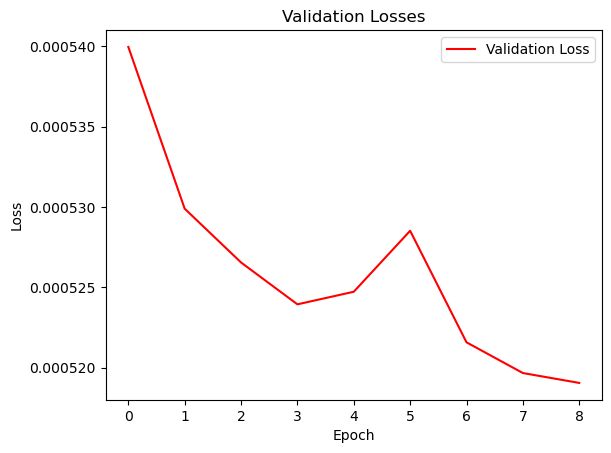

In [80]:
# Directory for saving the loss plots
filename_loss_png = f'outputs/deepSSF_S2_val_loss_buffalo{buffalo_id}_{today_date}.png'

# Plot the validation losses
plt.plot(val_losses, label='Validation Loss', color='red')  # Plot validation loss in red
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Show legend to distinguish lines
plt.savefig(filename_loss_png, dpi=600, bbox_inches='tight')
plt.show()

### Check model parameters

In [ ]:
# to look at the parameters (weights and biases) of the model
# print(model.state_dict())

# Loading in previous models

As we've trained the model, the model parameters are already stored in the `model` object. But as we were training the model, we were saving it to file, and that, and other trained models can be loaded. 

The model parameters that are being loaded must match the model object that has been defined above. If the model object has changed, the model parameters will not be able to be loaded.

In [81]:
path_save_weights

'model_checkpoints/deepSSF_S2_slope_buffalo2005_2025-02-09.pt'

### If loading a previously trained model

In [82]:
# to load previously saved weights
# path_save_weights = f'model_checkpoints/deepSSF_S2_slope_buffalo2005_2025-02-09.pt'

model.load_state_dict(torch.load(path_save_weights, 
                                 weights_only=True,
                                 map_location=torch.device('cpu')))

<All keys matched successfully>

## View model outputs

### Run model forward

Feature x1 batch shape: torch.Size([32, 13, 101, 101])
Feature x2 batch shape: torch.Size([32, 4])
Feature x3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])
[ 0.5         0.8660254  -0.99039733  0.1382503 ]
2.0000000556550703
281.8069779673261
-0.8930747


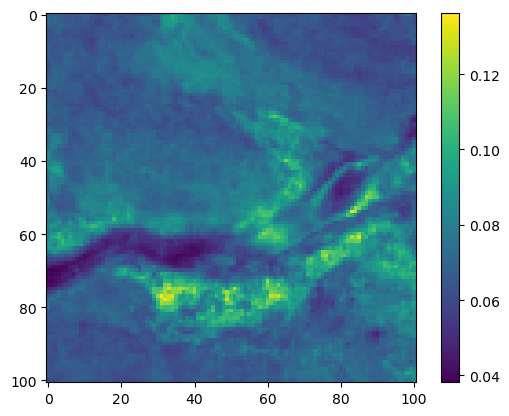

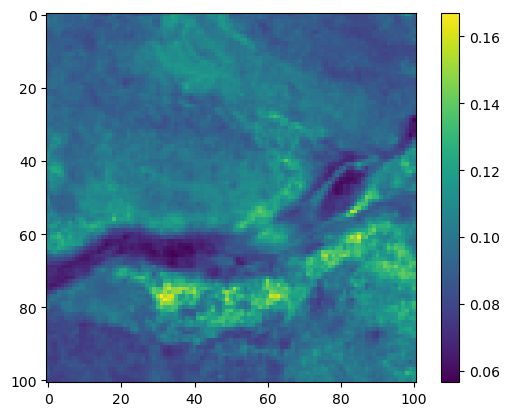

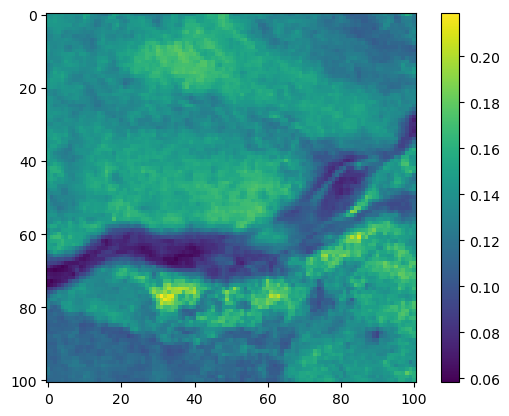

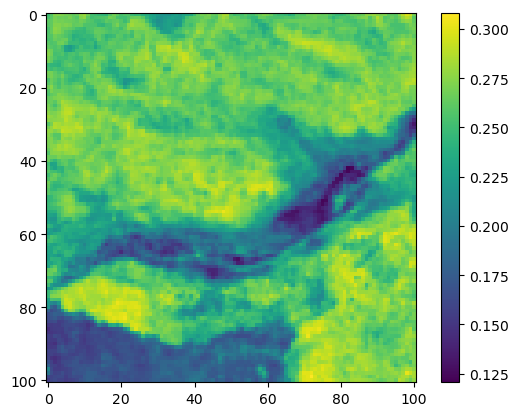

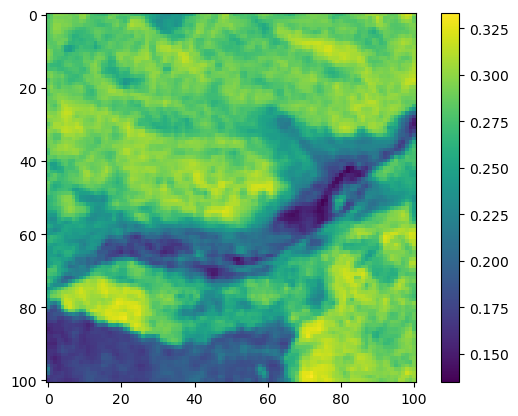

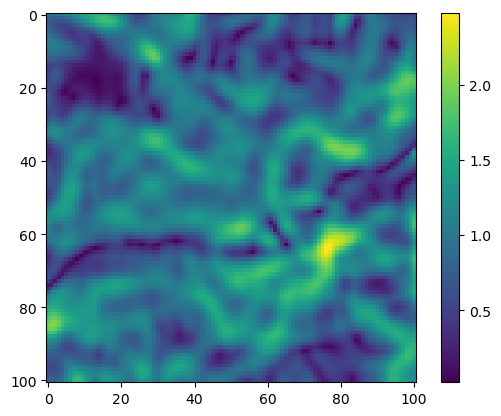

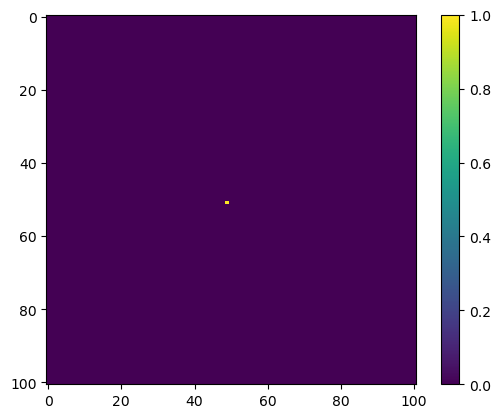

torch.Size([32, 101, 101, 2])


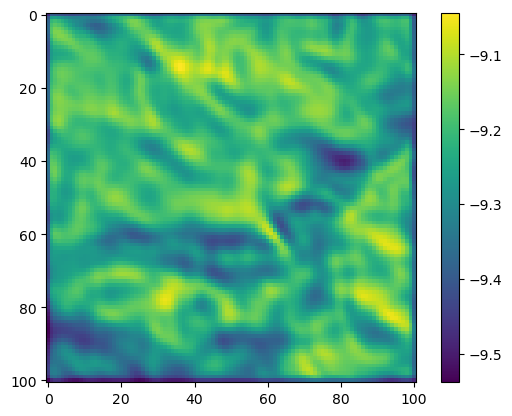

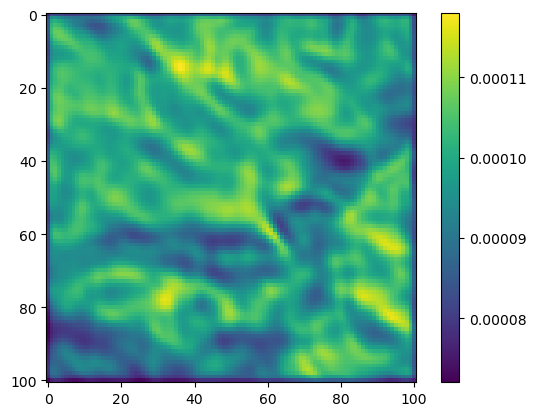

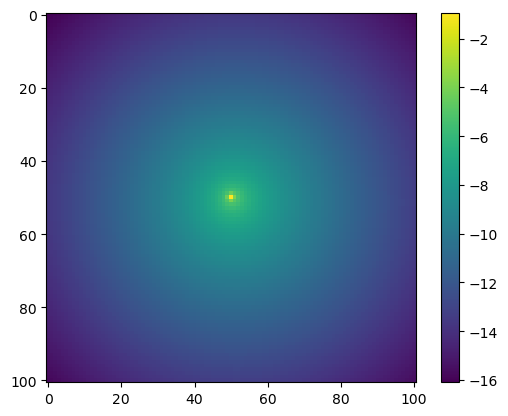

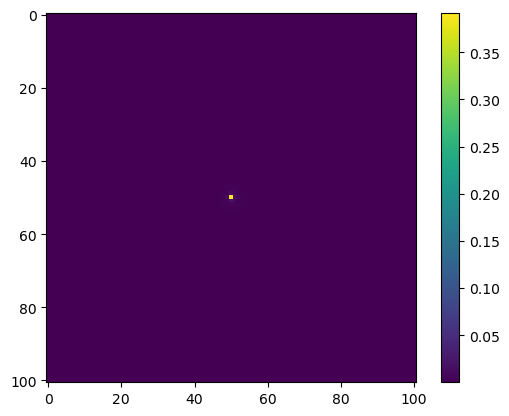

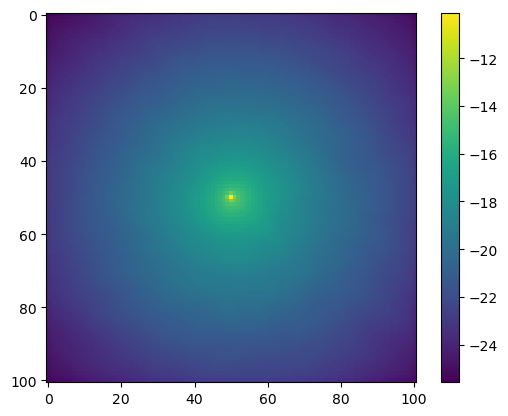

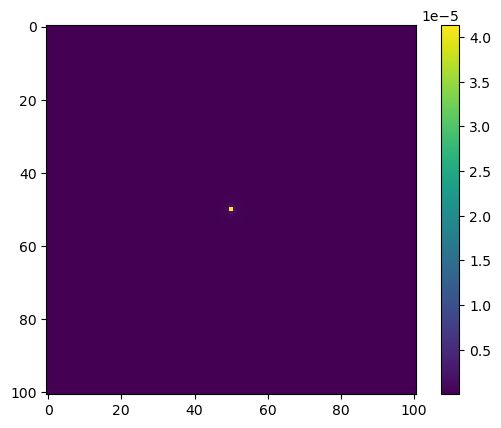

In [83]:
# 1. Set the model in evaluation mode
model.eval()

# Display image and label.
x1, x2, x3, labels = next(iter(dataloader_test))
print(f"Feature x1 batch shape: {x1.size()}")
print(f"Feature x2 batch shape: {x2.size()}")
print(f"Feature x3 batch shape: {x3.size()}")
# print(f"Feature x4 batch shape: {x3.size()}")
print(f"Labels batch shape: {labels.size()}")

print(x2.detach().numpy()[0,:])

# Pull out the scalars
hour_t2_sin = x2.detach().numpy()[0,0]
hour_t2_cos = x2.detach().numpy()[0,1]
yday_t2_sin = x2.detach().numpy()[0,2]
yday_t2_cos = x2.detach().numpy()[0,3]
# bearing_sin = x2.detach().numpy()[0,4]
# bearing_cos = x2.detach().numpy()[0,5]
bearing = x3.detach().numpy()[0,0]

def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
print(hour_t2)

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
print(yday_t2)

# def recover_bearing(bearing_sin, bearing_cos):
#     # Calculate the angle (bearing) in radians
#     bearing = np.arctan2(bearing_sin, bearing_cos)
#     # Convert bearing from radians to degrees
#     bearing_degrees = np.degrees(bearing) % 360
#     return bearing_degrees

# bearing = recover_bearing(bearing_sin, bearing_cos)
print(bearing)

# Move input tensors to the GPU if available
x1 = x1.to(device)
x2 = x2.to(device)
x3 = x3.to(device)

# print(loss_fn(model((x1, x2, x3)), labels))

# plot the covariates
# plt.imshow(x1.detach().cpu().numpy()[0,0,:,:])
# plt.colorbar()
# plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,1,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,2,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,3,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,7,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,8,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,12,:,:])
plt.colorbar()
plt.show()

# plot the target
plt.imshow(labels.detach().cpu().numpy()[0,:,:])
plt.colorbar()
plt.show()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,0])))

# plot the results of the habitat density as an image - in log scale
plt.imshow(test.detach().cpu().numpy()[0,:,:,0])
# plt.imshow(np.exp(test.detach().numpy()[0,:,:,0]))
plt.colorbar()
plt.show()

# plot the results of the habitat density as an image - as probabilities
# plt.imshow(test.detach().numpy()[0,:,:,0])
plt.imshow(np.exp(test.detach().cpu().numpy()[0,:,:,0]))
plt.colorbar()
plt.show()

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

# plot the results of the movement density as an image - in log scale
plt.imshow(test.detach().cpu().numpy()[0,:,:,1])
# plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

# plot the results of the movement density as an image - as probabilities
# plt.imshow(test.detach().numpy()[0,:,:,1])
plt.imshow(np.exp(test.detach().cpu().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

# results of the habitat and movement densities
# log-scale
test_cat = test[0, :, :, 0] + test[0, :, :, 1]
plt.imshow(test_cat.detach().cpu().numpy()[:,:])
plt.colorbar()
plt.show()

# exponentiated
test_cat = torch.exp(test[0, :, :, 0] + test[0, :, :, 1])
plt.imshow(test_cat.detach().cpu().numpy()[:,:])
plt.colorbar()
plt.show()

## Displaying as RGB image

In [ ]:
# 1. Set the model in evaluation mode
model.eval()

for i in range(0, 5):

  # Display image and label.
  x1, x2, x3, labels = next(iter(dataloader_test))
  print(f"Feature x1 batch shape: {x1.size()}")
  print(f"Feature x2 batch shape: {x2.size()}")
  print(f"Feature x3 batch shape: {x3.size()}")
  print(f"Feature x4 batch shape: {x3.size()}")
  print(f"Labels batch shape: {labels.size()}")

  print(x2.detach().numpy()[0,:])

  # Pull out the scalars
  hour_t2_sin = x2.detach().numpy()[0,0]
  hour_t2_cos = x2.detach().numpy()[0,1]
  yday_t2_sin = x2.detach().numpy()[0,2]
  yday_t2_cos = x2.detach().numpy()[0,3]
  bearing = x3.detach().numpy()[0,0]

  hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
  hour_t2_integer = int(hour_t2)  # Convert to integer
  print(f'Hour: {hour_t2_integer}')

  yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
  yday_t2_integer = int(yday_t2)  # Convert to integer
  print(f'Day of the year: {yday_t2_integer}')

  bearing_degrees = np.degrees(bearing) % 360
  bearing_degrees = round(bearing_degrees, 1)  # Round to 2 decimal places
  bearing_degrees = int(bearing_degrees)  # Convert to integer
  print(f'Bearing (radians): {bearing}')
  print(f'Bearing (degrees): {bearing_degrees}')

  # plot the covariates
  blue_layer = x1.detach().cpu().numpy()[0,1,:,:]
  green_layer = x1.detach().cpu().numpy()[0,2,:,:]
  red_layer = x1.detach().cpu().numpy()[0,3,:,:]

  # Return to natural scale
  blue_layer = blue_layer * (b2_max.cpu().numpy() - b2_min.cpu().numpy()) + b2_min.cpu().numpy()
  green_layer = green_layer * (b3_max.cpu().numpy() - b3_min.cpu().numpy()) + b3_min.cpu().numpy()
  red_layer = red_layer * (b4_max.cpu().numpy() - b4_min.cpu().numpy()) + b4_min.cpu().numpy()

  # Stack and display
  rgb_image_np = np.stack([red_layer, green_layer, blue_layer], axis=-1)

  # Normalize to the range [0, 1] for display
  rgb_image_np = (rgb_image_np - rgb_image_np.min()) / (rgb_image_np.max() - rgb_image_np.min())

  # plt.imshow(rgb_image_np)
  # plt.show()

  # slope
  # plt.imshow(x1.detach().cpu().numpy()[0,12,:,:])
  # plt.colorbar()
  # plt.show()

  # plot the target
  # plt.imshow(labels.detach().cpu().numpy()[0,:,:])
  # plt.colorbar()
  # plt.show()

  # Find the coordinates of the element that is 1
  target = labels.detach().cpu().numpy()[0,:,:]
  coordinates = np.where(target == 1)
  # Extract the coordinates
  row, column = coordinates[0][0], coordinates[1][0]
  print(f"The coordinates of the element that is 1 are (row, column): ({row}, {column})")


  # Run model

  # Move input tensors to the GPU if available
  x1 = x1.to(device)
  x2 = x2.to(device)
  x3 = x3.to(device)

  test = model((x1, x2, x3))
  print(test.shape)
  # print(test)

  # plot the results of the habitat density as an image
  hab_density = test.detach().cpu().numpy()[0,:,:,0]
  hab_density_exp = np.exp(hab_density)

  # Create the mask for x and y coordinates
  x_mask = np.ones_like(hab_density)
  y_mask = np.ones_like(hab_density)

  # mask out cells on the edges that affect the colour scale
  x_mask[:, :3] = -np.inf
  x_mask[:, 98:] = -np.inf
  y_mask[:3, :] = -np.inf
  y_mask[98:, :] = -np.inf

  hab_density_mask = hab_density * x_mask * y_mask
  hab_density_exp_mask = hab_density_exp * x_mask * y_mask

  # # plot the results of the habitat density as an image - in log scale
  # plt.imshow(hab_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the habitat density as an image - as probabilities
  # plt.imshow(hab_density_exp_mask)
  # plt.colorbar()
  # plt.show()

  # print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

  # movement probability
  move_density = test.detach().cpu().numpy()[0,:,:,1]
  move_density_exp = np.exp(move_density)

  move_density_mask = move_density * x_mask * y_mask
  move_density_exp_mask = move_density_exp * x_mask * y_mask

  # # plot the results of the movement density as an image - in log scale
  # plt.imshow(move_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the movement density as an image - as probabilities
  # plt.imshow(move_density_exp_mask)
  # plt.colorbar()
  # plt.show()


  # next step probability
  step_density = test[0, :, :, 0] + test[0, :, :, 1]
  step_density = step_density.detach().cpu().numpy()
  step_density_exp = np.exp(step_density)

  step_density_mask = step_density * x_mask * y_mask
  step_density_exp_mask = step_density_exp * x_mask * y_mask

  # # results of the habitat and movement densities
  # # log-scale
  # plt.imshow(step_density_mask)
  # plt.colorbar()
  # plt.show()

  # # exponentiated
  # plt.imshow(step_density_exp_mask)
  # plt.colorbar()
  # plt.show()


  # Plot the subset
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))

  # Plot RGB
  im1 = axs[0, 0].imshow(rgb_image_np)
  axs[0, 0].set_title('Sentinel-2 RGB')
  # fig.colorbar(im1, ax=axs[0, 0], shrink=0.7)

  # # Plot target
  # im2 = axs[0, 1].imshow(labels.detach().cpu().numpy()[0,:,:], cmap='viridis')
  # axs[0, 1].set_title('Observed next step')
  # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # Plot slope
  im2 = axs[0, 1].imshow(x1.detach().cpu().numpy()[0,12,:,:], cmap='viridis')
  axs[0, 1].set_title('Slope')
  fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # Plot habitat selection
  im3 = axs[1, 0].imshow(hab_density_mask, cmap='viridis')
  axs[1, 0].set_title('Habitat selection log-probability')
  fig.colorbar(im3, ax=axs[1, 0], shrink=0.7)

  # # Movement density
  # im3 = axs[1, 0].imshow(move_density_mask, cmap='viridis')
  # axs[1, 0].set_title('Movement log-probability')
  # fig.colorbar(im3, ax=axs[0, 1], shrink=0.7)

  # Next-step probability
  im4 = axs[1, 1].imshow(step_density_mask, cmap='viridis')
  axs[1, 1].set_title('Next-step log-probability')
  fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

  filename_covs = f'../buffalo_local_layers_id/rgb_steps/s2_slope_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
  plt.tight_layout()
  plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
  plt.show()
  plt.close()  # Close the figure to free memory


Output hidden; open in https://colab.research.google.com to view.

### Adding hooks to check movement parameters

In [ ]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Print the intermediate output
print("Intermediate output shape:", intermediate_output[0].shape)
print("Intermediate output values:", intermediate_output[0][0])

# Remove hook
hook_handle.remove()

# gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
# gamma_shape1, gamma_scale1, vonmises_mu1, vonmises_kappa1 = intermediate_output[0][0]


# Gamma 1 parameters
print("Gamma shape 1:", torch.exp(gamma_shape1))
print("Gamma scale 1:", torch.exp(gamma_scale1))
print("Gamma weight 1:", torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Gamma 2 parameters
print("Gamma shape 2:", torch.exp(gamma_shape2))
print("Gamma scale 2:", torch.exp(gamma_scale2)*500)
print("Gamma weight 2:", torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Von Mises 1 parameters
# print("Von Mises mu 1:", vonmises_mu1 % (2*np.pi))
print("Von Mises kappa 1:", torch.exp(vonmises_kappa1))
print("Von Mises weight 1:", torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))

# Von Mises 2 parameters
# print("Von Mises mu 2:", vonmises_mu2 % (2*np.pi))
print("Von Mises kappa 2:", torch.exp(vonmises_kappa2))
print("Von Mises weight 2:", torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))


Intermediate output shape: torch.Size([32, 12])
Intermediate output values: tensor([ 0.5389,  1.1857,  0.4089, -3.4108, -0.4617, -1.8975, -0.4292, -1.3728,
        -0.3129,  0.3111, -0.7425,  0.2803], device='cuda:0')
Gamma shape 1: tensor(1.7142, device='cuda:0')
Gamma scale 1: tensor(3.2729, device='cuda:0')
Gamma weight 1: tensor(0.9094, device='cuda:0')
Gamma shape 2: tensor(0.0330, device='cuda:0')
Gamma scale 2: tensor(315.0984, device='cuda:0')
Gamma weight 2: tensor(0.0906, device='cuda:0')
Von Mises kappa 1: tensor(0.2534, device='cuda:0')
Von Mises weight 1: tensor(0.3559, device='cuda:0')
Von Mises kappa 2: tensor(0.4759, device='cuda:0')
Von Mises weight 2: tensor(0.6441, device='cuda:0')


Plot the distributions

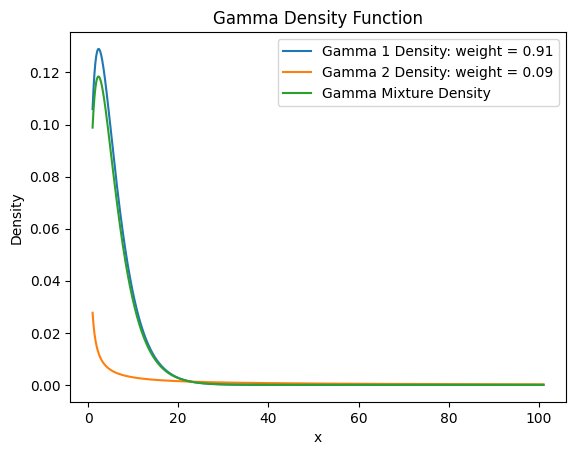

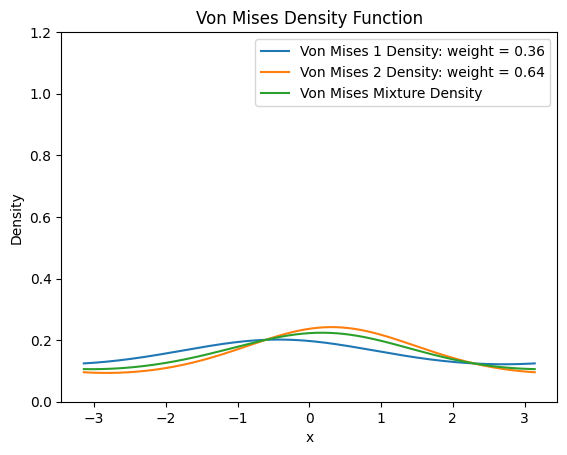

In [ ]:
# Gamma densities for the mixture distribution
def gamma_density(x, shape, scale):
    return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

# von Mises densities for the mixture distribution
def vonmises_density(x, kappa, vm_mu):
    return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


### Round the weight variables

# Gamma weights
gamma_weight1_recovered = torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight1 = round(gamma_weight1_recovered.item(), 2)
gamma_weight2_recovered = torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight2 = round(gamma_weight2_recovered.item(), 2)

# von Mises weights
vonmises_weight1_recovered = torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight1 = round(vonmises_weight1_recovered.item(), 2)
vonmises_weight2_recovered = torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight2 = round(vonmises_weight2_recovered.item(), 2)


# parameters of the Gamma mixture distributions
# Generate x values from 1 to 1000
x_values = torch.linspace(1, 101, 1000).to(device)
gamma1_density = gamma_density(x_values, torch.exp(gamma_shape1), torch.exp(gamma_scale1))
gamma2_density = gamma_density(x_values, torch.exp(gamma_shape2), torch.exp(gamma_scale2)*500)
gamma_mixture_density = gamma_weight1_recovered*torch.exp(gamma1_density) + gamma_weight2_recovered*torch.exp(gamma2_density)

# Move tensors to CPU and convert to NumPy arrays
x_values_np = x_values.cpu().numpy()
gamma1_density_np = np.exp(gamma1_density.cpu().numpy())  # Move to CPU before np.exp
gamma2_density_np = np.exp(gamma2_density.cpu().numpy())  # Move to CPU before np.exp
gamma_mixture_density_np = gamma_mixture_density.cpu().numpy()

# Plot the gamma density function
# plt.plot(x_values_np, gamma1_density_np, label='Gamma 1 Density')
plt.plot(x_values_np, gamma1_density_np, label=f'Gamma 1 Density: weight = {rounded_gamma_weight1}')
plt.plot(x_values_np, gamma2_density_np, label=f'Gamma 2 Density: weight = {rounded_gamma_weight2}')
plt.plot(x_values_np, gamma_mixture_density_np, label='Gamma Mixture Density')
# plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gamma Density Function')
plt.legend()
plt.show()

# parameters of the von mises mixture distribution
# Generate x values from -pi to pi
x_values = torch.linspace(-np.pi, np.pi, 1000).to(device)
vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), vonmises_mu1)
vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), vonmises_mu2)
# vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), 0)
# vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), -torch.pi)
vonmises_mixture_density = vonmises_weight1_recovered*torch.exp(vonmises1_density) + vonmises_weight2_recovered*torch.exp(vonmises2_density)

# Move tensors to CPU and convert to NumPy arrays
x_values_np = x_values.cpu().numpy() # Move x_values to cpu
vonmises1_density_np = np.exp(vonmises1_density.cpu().numpy())  # Move to CPU before np.exp
vonmises2_density_np = np.exp(vonmises2_density.cpu().numpy())  # Move to CPU before np.exp
vonmises_mixture_density_np = vonmises_mixture_density.cpu().numpy() # Move vonmises_mixture_density to cpu

# Plot the von mises density function
# plt.plot(x_values_np, vonmises1_density_np, label='Von Mises 1 Density')
plt.plot(x_values_np, vonmises1_density_np, label=f'Von Mises 1 Density: weight = {rounded_vm_weight1}')
plt.plot(x_values_np, vonmises2_density_np, label=f'Von Mises 2 Density: weight = {rounded_vm_weight2}')
plt.plot(x_values_np, vonmises_mixture_density_np, label='Von Mises Mixture Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Von Mises Density Function')
plt.ylim(0, 1.2)  # Set the y-axis limits
plt.legend()
plt.show()

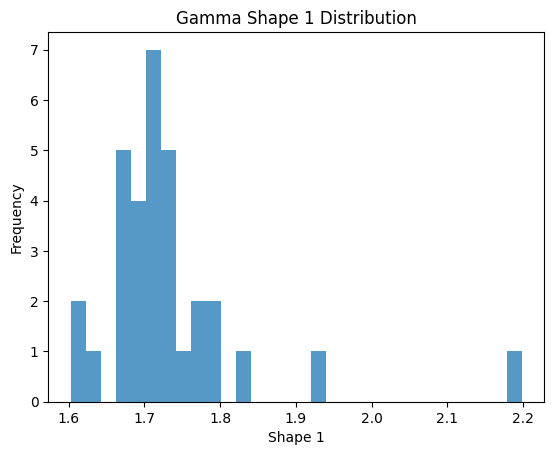

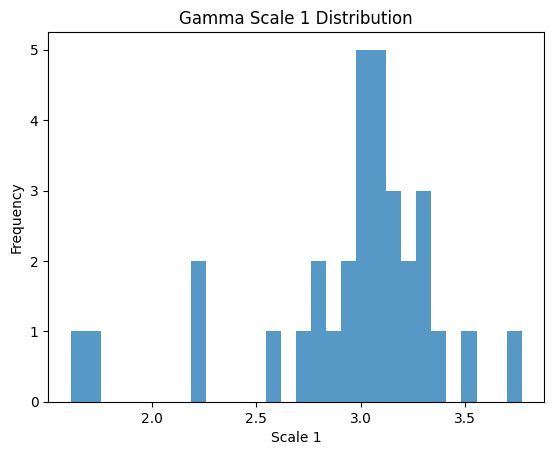

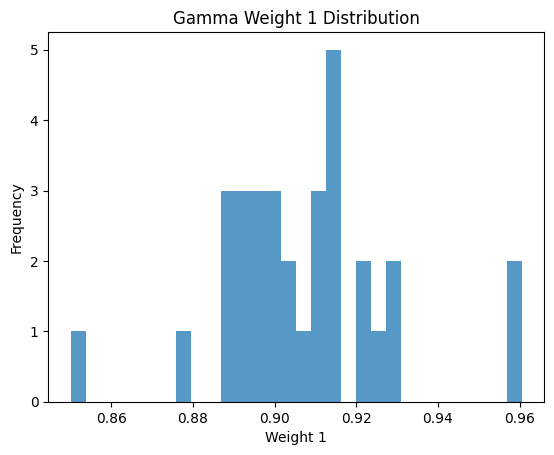

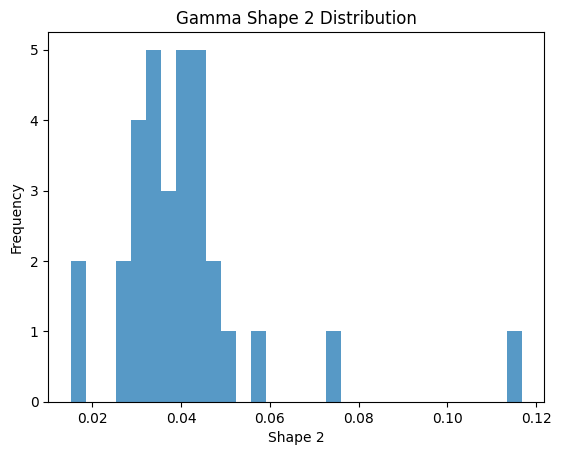

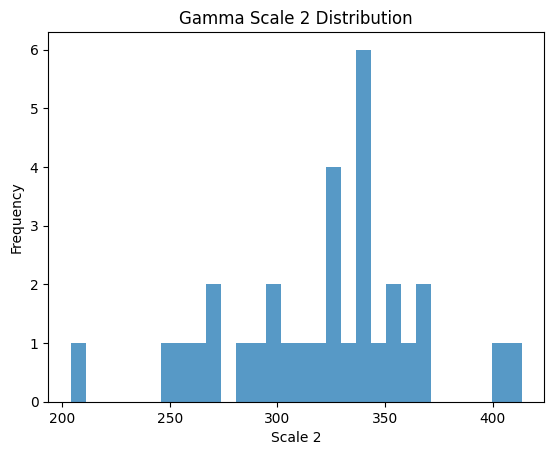

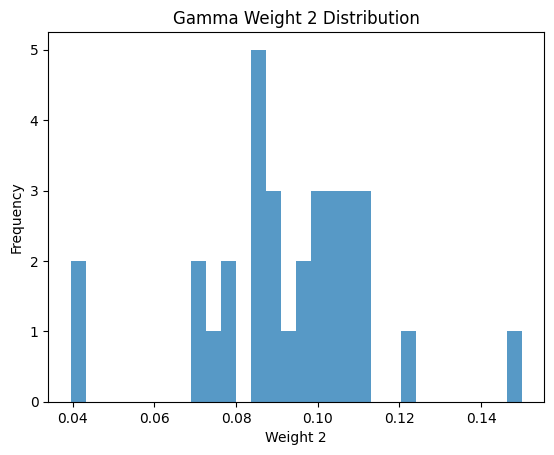

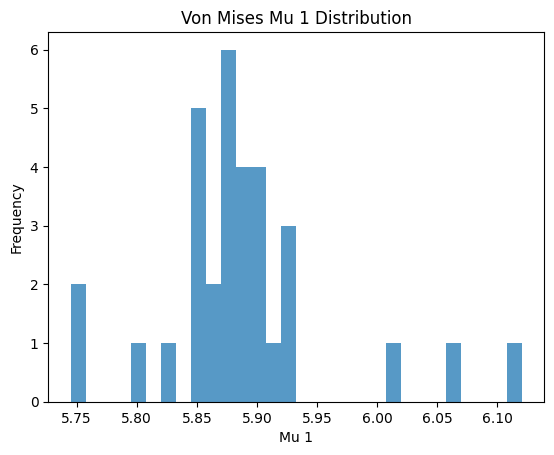

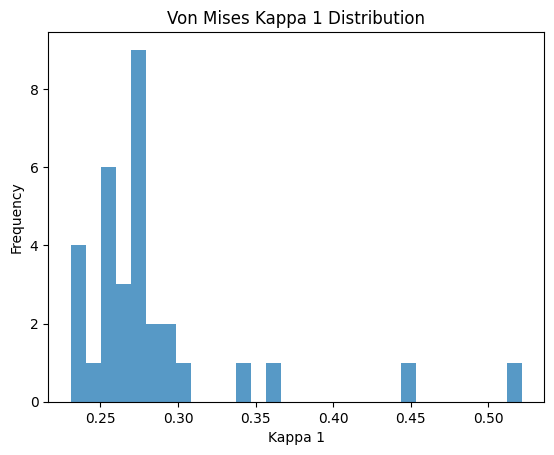

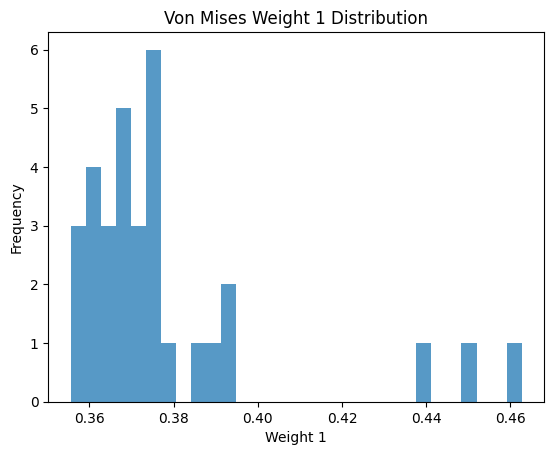

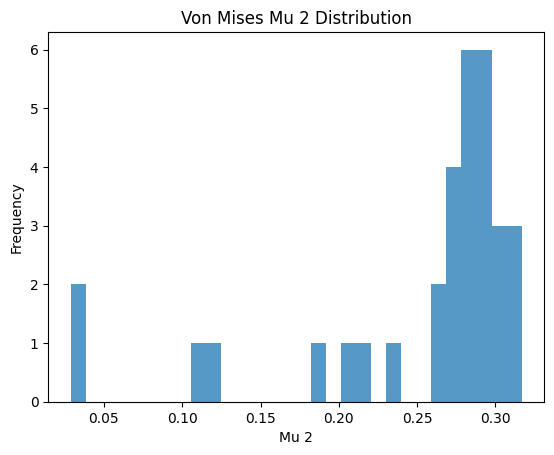

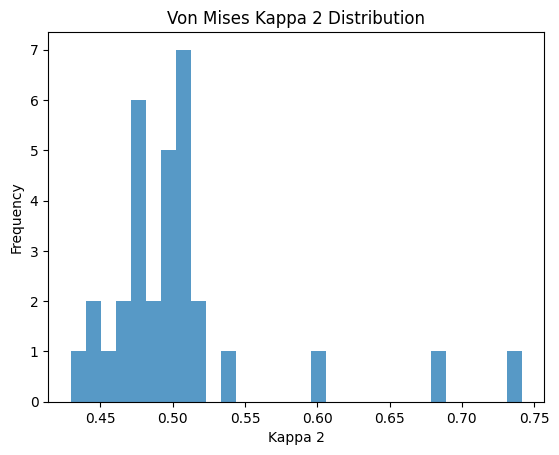

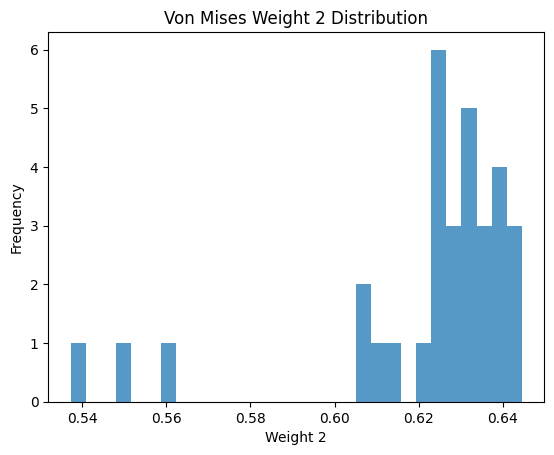

In [ ]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Extract parameters for each batch
gamma_shape1_list = []
gamma_scale1_list = []
gamma_weight1_list = []
gamma_shape2_list = []
gamma_scale2_list = []
gamma_weight2_list = []
vonmises_mu1_list = []
vonmises_kappa1_list = []
vonmises_weight1_list = []
vonmises_mu2_list = []
vonmises_kappa2_list = []
vonmises_weight2_list = []

for batch_output in intermediate_output:
    for sample_output in batch_output:
      # gamma_shape1, gamma_scale1, vonmises_mu1, vonmises_kappa1 = sample_output
      # gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = sample_output
      gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = sample_output

      gamma_shape1_list.append(torch.exp(gamma_shape1).item())
      gamma_scale1_list.append(torch.exp(gamma_scale1).item())
      gamma_weight1_list.append((torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
      gamma_shape2_list.append(torch.exp(gamma_shape2).item())
      gamma_scale2_list.append((torch.exp(gamma_scale2)*500).item())
      gamma_weight2_list.append((torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
      vonmises_mu1_list.append((vonmises_mu1 % (2*np.pi)).item())
      vonmises_kappa1_list.append(torch.exp(vonmises_kappa1).item())
      vonmises_weight1_list.append((torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())
      vonmises_mu2_list.append((vonmises_mu2 % (2*np.pi)).item())
      vonmises_kappa2_list.append(torch.exp(vonmises_kappa2).item())
      vonmises_weight2_list.append((torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())

# Plot parameters
def plot_histogram(data, title, xlabel):
    plt.figure()
    plt.hist(data, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(gamma_shape1_list, 'Gamma Shape 1 Distribution', 'Shape 1')
plot_histogram(gamma_scale1_list, 'Gamma Scale 1 Distribution', 'Scale 1')
plot_histogram(gamma_weight1_list, 'Gamma Weight 1 Distribution', 'Weight 1')
plot_histogram(gamma_shape2_list, 'Gamma Shape 2 Distribution', 'Shape 2')
plot_histogram(gamma_scale2_list, 'Gamma Scale 2 Distribution', 'Scale 2')
plot_histogram(gamma_weight2_list, 'Gamma Weight 2 Distribution', 'Weight 2')
plot_histogram(vonmises_mu1_list, 'Von Mises Mu 1 Distribution', 'Mu 1')
plot_histogram(vonmises_kappa1_list, 'Von Mises Kappa 1 Distribution', 'Kappa 1')
plot_histogram(vonmises_weight1_list, 'Von Mises Weight 1 Distribution', 'Weight 1')
plot_histogram(vonmises_mu2_list, 'Von Mises Mu 2 Distribution', 'Mu 2')
plot_histogram(vonmises_kappa2_list, 'Von Mises Kappa 2 Distribution', 'Kappa 2')
plot_histogram(vonmises_weight2_list, 'Von Mises Weight 2 Distribution', 'Weight 2')

# Remove hook
hook_handle.remove()

tensor([[[-14.5482, -14.4791, -14.4105,  ..., -14.2017, -14.2680, -14.3349],
         [-14.4864, -14.4165, -14.3471,  ..., -14.1360, -14.2032, -14.2709],
         [-14.4252, -14.3545, -14.2843,  ..., -14.0710, -14.1390, -14.2075],
         ...,
         [-14.9054, -14.8396, -14.7744,  ..., -14.5475, -14.6105, -14.6741],
         [-14.9716, -14.9066, -14.8421,  ..., -14.6175, -14.6797, -14.7425],
         [-15.0383, -14.9740, -14.9103,  ..., -14.6879, -14.7494, -14.8114]]],
       device='cuda:0', dtype=torch.float64)
torch.Size([1, 101, 101])


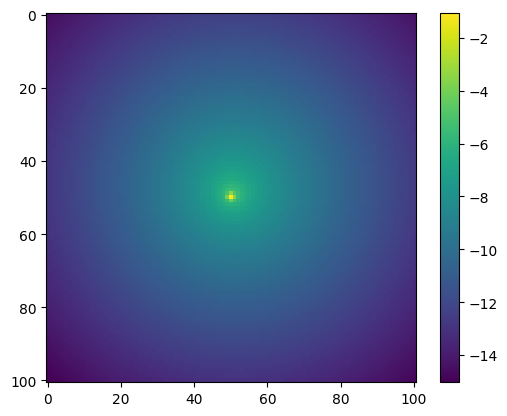

In [ ]:
test_bearing = torch.tensor([[1.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
# movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
#                                              np.log(2.5), np.log(300), np.log(0.75), # gamma 2 - shape, scale and weight
#                                              5, np.log(1), np.log(0.75),
#                                              -10, np.log(1.5), np.log(0.25)]], device=device), test_bearing)

movement_density = test_block(intermediate_output[0][0].unsqueeze(dim = 0), test_bearing)
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density.detach().cpu()[0])
plt.colorbar()
plt.show()

### Visualise CNN layers

In [ ]:
# Visualize the intermediate activations
# for layer_name, activation in activations.items():
#     print(f'Layer: {layer_name}, Shape: {activation.shape}')
#     plt.imshow(activation[0, 0].cpu().numpy(), cmap='gray')
#     plt.title(layer_name)
#     plt.show()